In [1]:
from image_dataset import create_dataloader
from torchvision import transforms

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
new_size = (512, 512)
patch_size = 512 // 16
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda img: img.repeat(3//img.shape[0], 1, 1)),
    transforms.Resize(new_size),
                       ]
                              )
dataloader = create_dataloader(
    data_type = 'train',
    selected_categories = ['person', 'skis'],
    selected_output = ['bbox', ],
    new_size = new_size,
    patch_size = patch_size,
    transform = transform,
    batch_size = 4
    )


In [3]:
test_data = next(iter(dataloader))
for key, value in test_data.items():
    print(key, value.shape)

images torch.Size([4, 3, 512, 512])
output_to_rpns torch.Size([4, 16, 16, 2])
bboxs torch.Size([9, 4])
category_ids torch.Size([9])
center_widths torch.Size([9])
center_heights torch.Size([9])
img_ids torch.Size([9])


In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import transformers
import torch.optim as optim
class ResNetModel(nn.Module):
  def __init__(self, resnet_config, output_dim, device='cpu'):
    super(ResNetModel, self).__init__()
    self.baseline = transformers.ResNetModel(resnet_config).to(device)
    self.lin1 = nn.Linear(resnet_config.hidden_sizes[-1],
                                1024,
                                device=device)
    self.output_rpn = nn.Linear(1024,
                                output_dim,
                                device=device)

  def forward(self, x):
    last_hidden_state, _ = self.baseline(x, return_dict=False)
    last_hidden_state = last_hidden_state.permute(0, 2, 3, 1)
    # last_hidden_state = output['last_hidden_state']
    x = self.lin1(last_hidden_state)
    x = F.gelu(x)
    rpn_output = self.output_rpn(x)
    return rpn_output, last_hidden_state

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_config = transformers.ResNetConfig(num_channels=3,
                                          embedding_size=64,
                                          #hidden_sizes=(64, 128, 256, 512, 1024),
                                          hidden_act='gelu',
                                          #depths = [3, 3, 3, 3, 3, 3],
                                          device = device)
resnet_model = ResNetModel(resnet_config,
                           output_dim=2,
                           device = device)

In [26]:
resnet_model(test_data['images'].to(device))[0].shape

torch.Size([4, 16, 16, 2])

In [27]:
torch.cuda.empty_cache()

In [28]:
loss_fn_rpn = nn.BCEWithLogitsLoss()
resnet_optimizer = optim.AdamW(resnet_model.parameters(), lr=2e-4)
resnet_scheduler = transformers.get_linear_schedule_with_warmup(optimizer=resnet_optimizer,
                                                                num_warmup_steps=3000,
                                                                num_training_steps=100000)

In [29]:
import matplotlib.pyplot as plt

Epoch: 0, step: 35, last loss: 0.6218931674957275, max prob: 0.5888235569000244


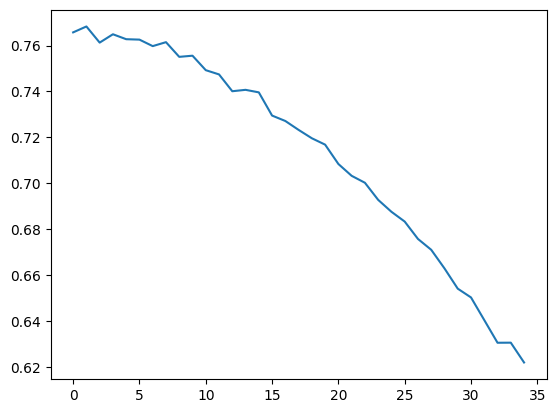

Epoch: 0, step: 70, last loss: 0.3684384226799011, max prob: 0.4411810636520386


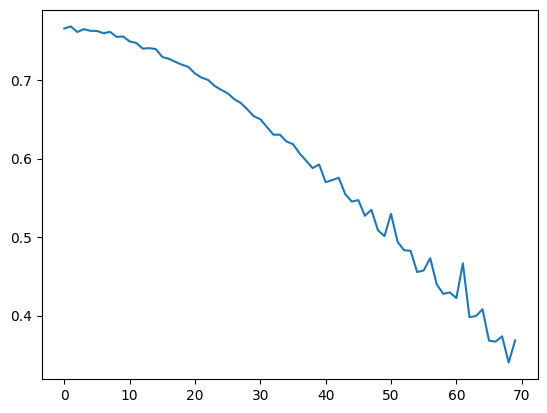

Epoch: 0, step: 105, last loss: 0.15078727900981903, max prob: 0.2593427300453186


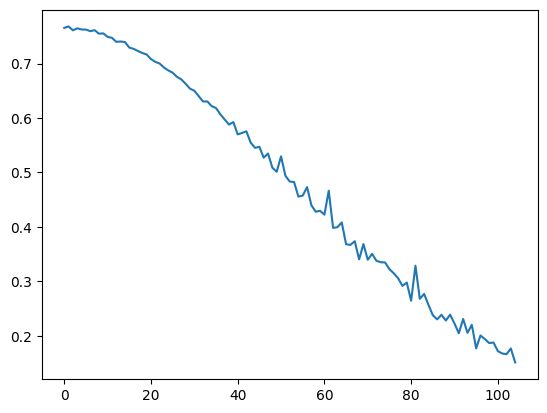

Epoch: 0, step: 140, last loss: 0.08124536275863647, max prob: 0.14990270137786865


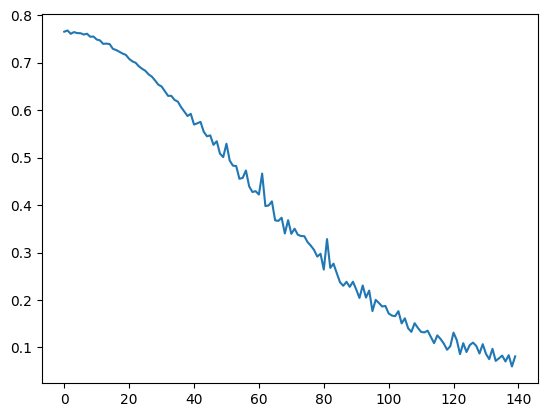

Epoch: 0, step: 175, last loss: 0.06220165640115738, max prob: 0.09391717612743378


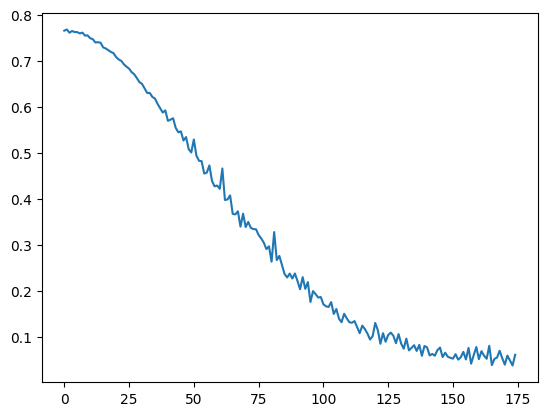

Epoch: 0, step: 210, last loss: 0.05514071136713028, max prob: 0.06769565492868423


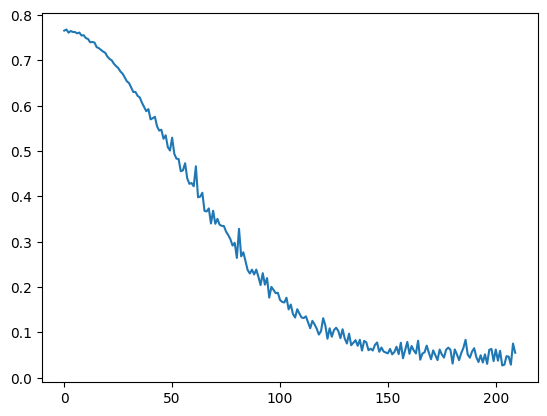

Epoch: 0, step: 245, last loss: 0.04739806056022644, max prob: 0.0670500248670578


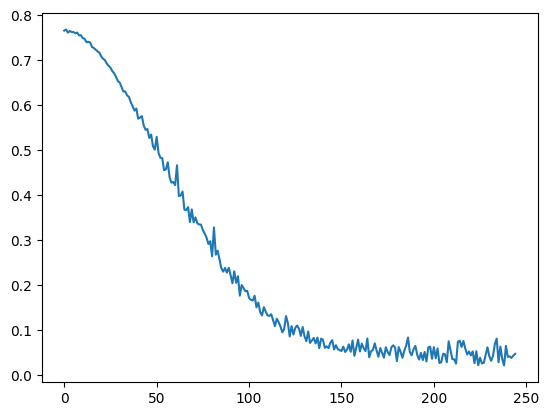

Epoch: 0, step: 280, last loss: 0.0413152277469635, max prob: 0.06972743570804596


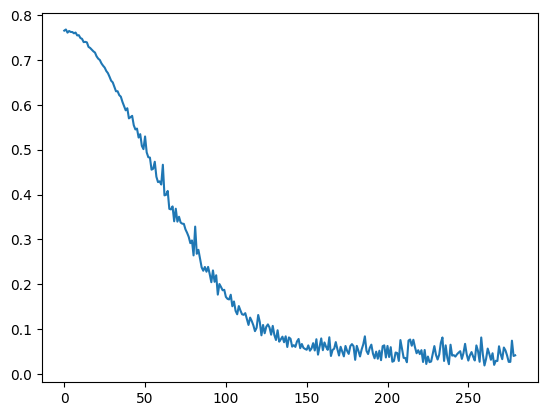

Epoch: 0, step: 315, last loss: 0.02413078397512436, max prob: 0.041320569813251495


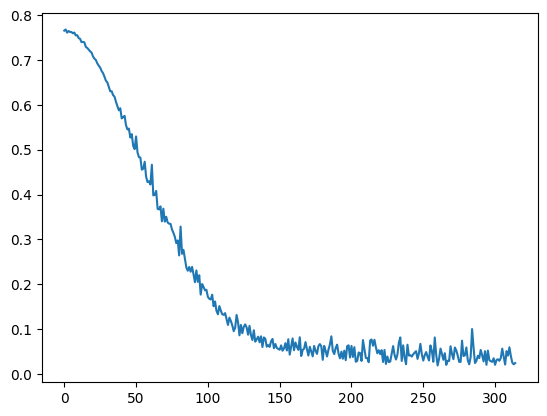

Epoch: 0, step: 350, last loss: 0.05027040094137192, max prob: 0.07612256705760956


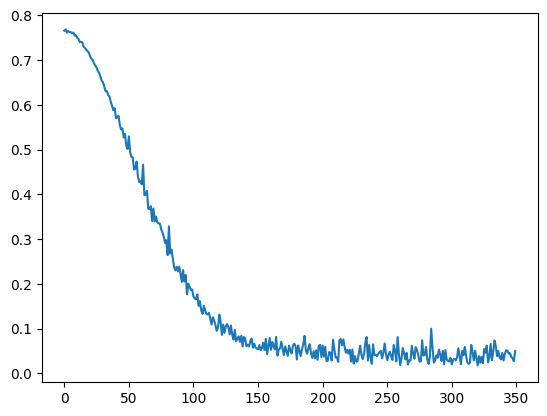

Epoch: 0, step: 385, last loss: 0.07026677578687668, max prob: 0.058976393193006516


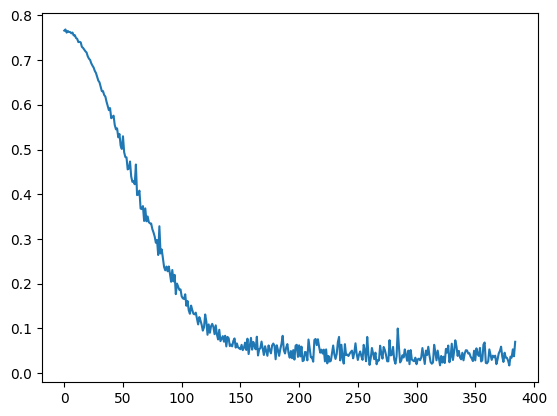

Epoch: 0, step: 420, last loss: 0.05757242441177368, max prob: 0.06970057636499405


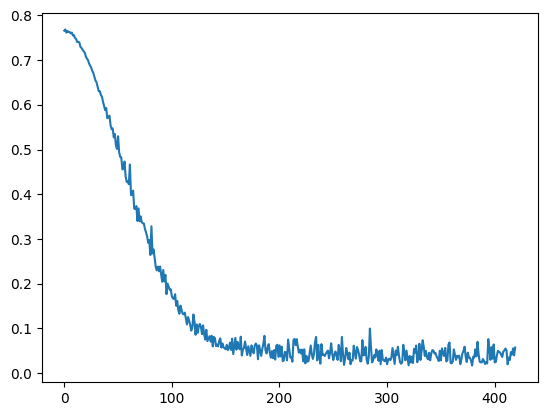

Epoch: 0, step: 455, last loss: 0.022116824984550476, max prob: 0.05353432148694992


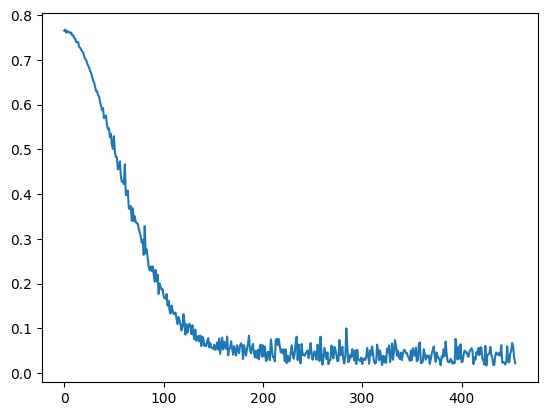

Epoch: 0, step: 490, last loss: 0.09288115054368973, max prob: 0.06853991001844406


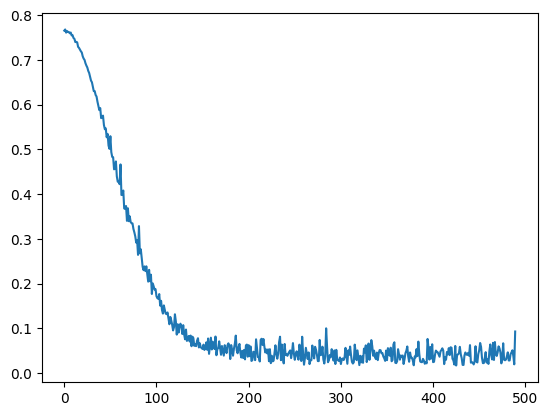

Epoch: 0, step: 525, last loss: 0.028947487473487854, max prob: 0.045829884707927704


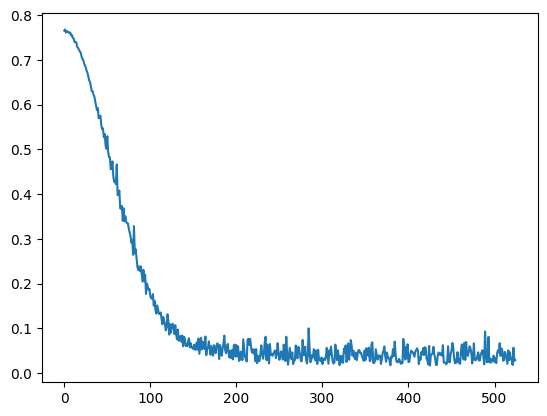

Epoch: 0, step: 560, last loss: 0.03278272971510887, max prob: 0.06304998695850372


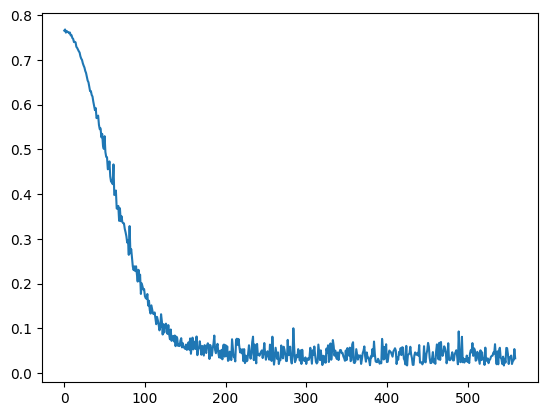

Epoch: 0, step: 595, last loss: 0.07641005516052246, max prob: 0.07909738272428513


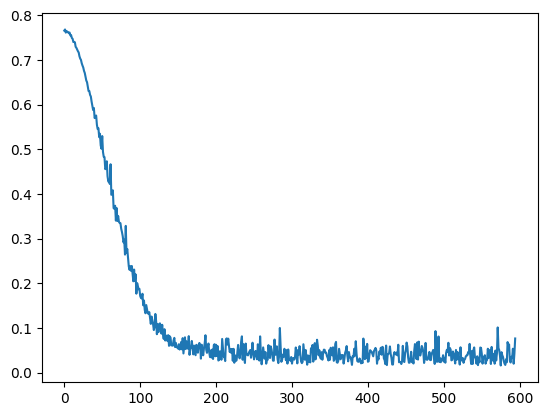

In [ ]:
epochs = 5
losses = []
step = 0
step_show = 35

for epoch in range(epochs):
    for data in dataloader:
        resnet_optimizer.zero_grad()
        image_data = data['images'].to(device)
        target_rpn = data['output_to_rpns'].to(device)
        rpn_output, _ = resnet_model(image_data)
        loss = loss_fn_rpn(rpn_output, target_rpn)
        loss.backward()
        resnet_optimizer.step()
        resnet_scheduler.step()
        losses.append(loss.item())
        step += 1
        if step % step_show == 0:
            print(f'Epoch: {epoch}, step: {step}, last loss: {loss.item()}, max prob: {nn.Sigmoid()(rpn_output.detach()).max().item()}')
            plt.plot(losses)
            plt.show()
            plt.close()
            